In [1]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet

In [3]:
import mne
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET


from KC_algorithm.model import score_KCs
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs
################################################################
# Healper function to load the hypnogram from the NSRR .xml file


def import_event_and_stages_CFS(xml_file):
    """
    Helper function to import stages and events of the Cleveland family study
    :param xml_file: xml file from NSRR CFS files
    :param reject_epochs_with_overlapping_events: bool, if True, will reject epochs with any overlapping events
    :return:
    - events: a dataframe with key 'onset', 'dur', 'label', covering each events, their onset, duration and its labels
    - events: same as events but with stages
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    events = pd.DataFrame()
    stages = pd.DataFrame()

    events['label'] = [child.text for child in root.findall("./ScoredEvents/ScoredEvent/Name")]
    events['onset'] = np.asarray([child.text for child in root.findall("./ScoredEvents/ScoredEvent/Start")],
                                 dtype='float')
    events['dur'] = np.asarray([child.text for child in root.findall("./ScoredEvents/ScoredEvent/Duration")],
                               dtype='float')


    stages['label'] = np.asarray([child.text for child in root.findall("./SleepStages/SleepStage")], dtype='int')
    stages['dur'] = np.ones_like(stages['label']) * np.asarray([child.text for child in root.findall("./EpochLength")],
                                                               dtype='int')
    stages['onset'] = np.cumsum(stages['dur']) - np.asarray([child.text for child in root.findall("./EpochLength")],
                                                               dtype='int')

    return events, stages

def run(edf_filename, annot_filename):

    ######### Pre-processing ###########
    raw = mne.io.read_raw_edf(edf_filename, preload=True)
    raw, _ = mne.set_eeg_reference(raw, [], verbose='warning') # data is already referenced in this NSRR file
    raw.resample(128)
    raw = raw.filter(0.3, None)


    ## Import hypnogram ##
    events, hypno = import_event_and_stages_CFS(xml_file=annot_filename)
    
    print(hypno['dur'])


    ## Parameters for K-complex scoring##
    wanted_channel = 'EEG' # EEG = C3 in NSRR files
    wanted_sleep_stages = [2]
    # we multiply the channel by -1 since the algorithm was trained on negative EEG polarity
    C3 = np.asarray(
        [raw[count, :][0] for count, k in enumerate(raw.info['ch_names']) if
         k == wanted_channel]).ravel()*-1
    Fs = raw.info['sfreq']



    peaks, stage_peaks, d, probas = score_KCs(C3, Fs, hypno, sleep_stages=wanted_sleep_stages)


    #######################################################################
    probability_threshold = 0.5 # include only waveform scored with a probability of at least 50%

    labels_detected = np.where(probas>probability_threshold,1,0)
    onsets_detected = peaks[probas>probability_threshold]
    probas_detected = probas[probas>probability_threshold]

    print('{} K-complexes were detected'.format(np.sum(labels_detected)))
    #

    ########################################################################
    ####                        VIZUALISATION                           ####

    ##----- Average K-complexes for different probability threshold ------##
    KC_from_probas(C3*-1,onsets_detected,probas_detected,Fs)
    plot_all_Kcs(C3 * -1, peaks, probas, Fs)
    
    ##------------------------Plotting with mne --------------------------##

    tmin = -2
    tmax= 2

    events_mne = np.vstack([onsets_detected, np.zeros_like(onsets_detected), np.ones_like(onsets_detected)]).T

    # Use the correct channel names in picks
    ep = mne.Epochs(raw, events_mne, picks='eeg', baseline=None, tmin=tmin, tmax=tmax)

    
    # Plot each individuals K-complexes
    ep.plot(block=True)

    # Plot a similar Figure 4 in our manuscript
    ep.plot_image(group_by=None, picks='eeg', vmin=-200, vmax=200)

Extracting EDF parameters from /home/ec2-user/SageMaker/datasets/nsrr/learn/polysomnography/edfs/learn-nsrr01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10229999  =      0.000 ... 40919.996 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 1409 samples (11.008 s)

0       30
1       30
2       30
3       30
4       30
        ..
1359    30
1360    30
1361    30
1362    30
1363    30
Name: dur, Length: 1364, dtype: int64
251 K-complexes were detected


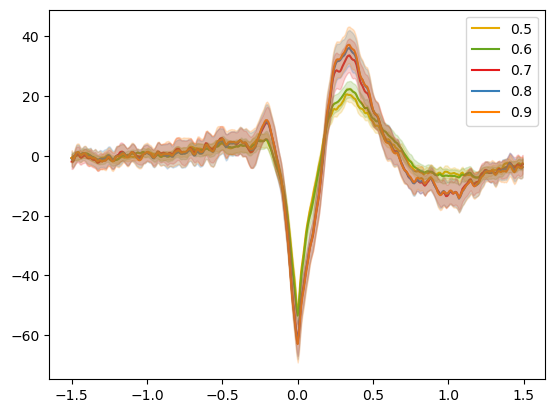

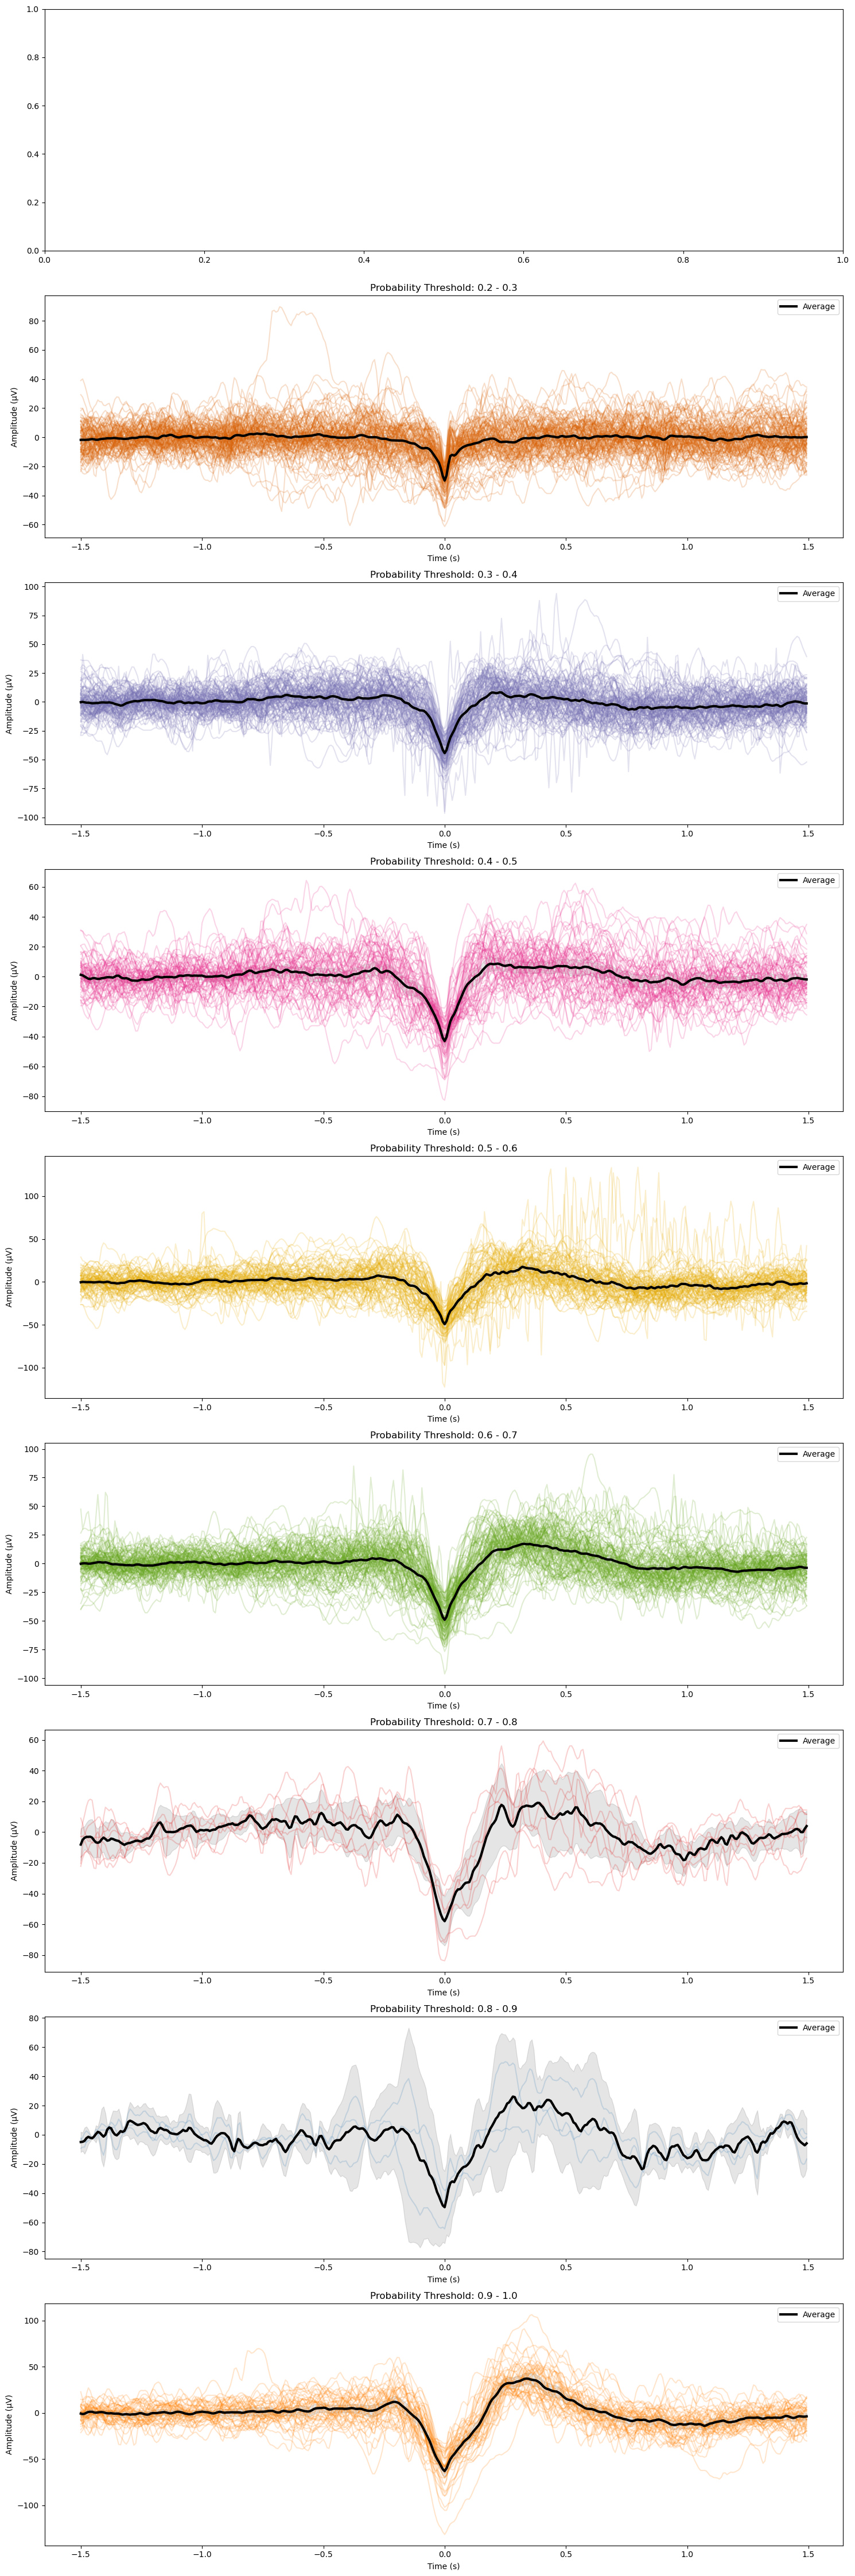

Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 251 events and 513 original time points ...
0 bad epochs dropped
Using matplotlib as 2D backend.
Using data from preloaded Raw for 20 events and 513 original time points ...


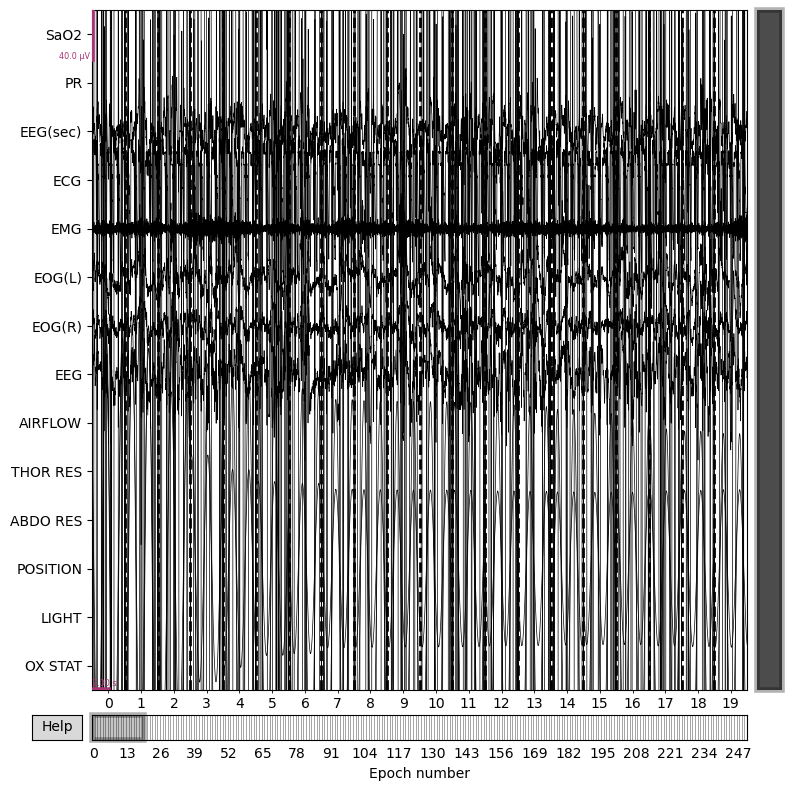

Using data from preloaded Raw for 251 events and 513 original time points ...
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


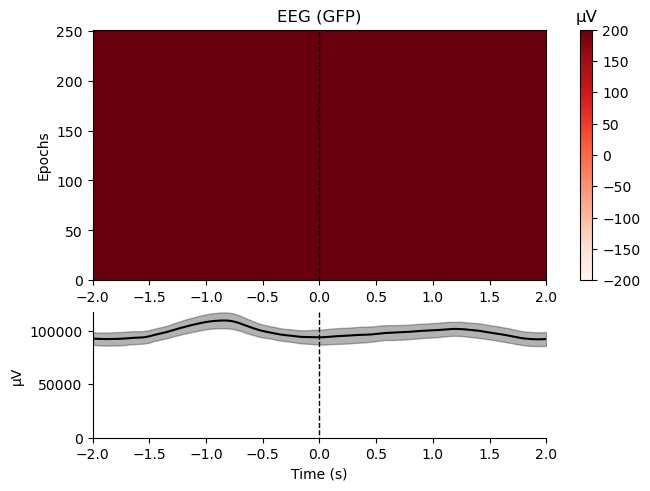

In [4]:
import os
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/learn/polysomnography/"

EDF_FILENAME = os.path.join(DATASET_DIR, 'edfs/learn-nsrr01.edf')
ANNOT_FILENAME = os.path.join(DATASET_DIR, 'annotations-events-profusion/learn-nsrr01-profusion.xml')

run(EDF_FILENAME, ANNOT_FILENAME)